In [1]:
pip install Datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [15]:
pip install evaluate

In [3]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset


In [4]:
# Load dataset
df = pd.read_csv('impression_300_llm.csv')

# Prepare data for fine-tuning
def prepare_data_for_fine_tuning(df):
    df.fillna('', inplace=True)
    df['input_text'] = (
        "Report Name: " + df['Report Name'] +
        "\nHistory: " + df['History'] +
        "\nObservation: " + df['Observation']
    ).str.strip()

    df['output_text'] = df['Impression'].str.strip()
    return df[['input_text', 'output_text']]

# Prepare the dataset
prepared_df = prepare_data_for_fine_tuning(df)

# Split the dataset into training and evaluation sets
train_df, eval_df = train_test_split(prepared_df, test_size=0.1, random_state=42)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)


In [5]:
# Load T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-base')

def tokenize_function(examples):
    model_inputs = tokenizer(examples['input_text'], padding='max_length', truncation=True, max_length=512)
    # Set the labels for the model
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['output_text'], padding='max_length', truncation=True, max_length=128)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize the datasets
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
tokenized_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/297 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/33 [00:00<?, ? examples/s]

In [6]:
# Load T5 model for conditional generation
model = T5ForConditionalGeneration.from_pretrained('t5-base')
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    evaluation_strategy='epoch',     # evaluation strategy to adopt during training
    learning_rate=2e-5,              # learning rate
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    num_train_epochs=3,              # total number of training epochs
    weight_decay=0.01,               # strength of weight decay
)
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_eval_dataset,
)

# Train the model
trainer.train()


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,1.653113
2,No log,1.049611
3,No log,1.006767


TrainOutput(global_step=114, training_loss=2.2170137104235197, metrics={'train_runtime': 183.7599, 'train_samples_per_second': 4.849, 'train_steps_per_second': 0.62, 'total_flos': 542581480488960.0, 'train_loss': 2.2170137104235197, 'epoch': 3.0})

In [7]:
# Evaluate the model
trainer.evaluate()


{'eval_loss': 1.0067671537399292,
 'eval_runtime': 2.1153,
 'eval_samples_per_second': 15.601,
 'eval_steps_per_second': 2.364,
 'epoch': 3.0}

In [8]:
# Save the model and tokenizer
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")


('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/spiece.model',
 './fine_tuned_model/added_tokens.json')

In [10]:
# Generate text for the evaluation dataset
def generate_impressions(prompt):
    # Tokenize input prompt and send to device (GPU)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    # Generate output
    outputs = model.generate(inputs["input_ids"], max_length=150)
    # Decode the generated output
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Iterate through the evaluation set and generate impressions
generated_impressions = []
for idx, example in enumerate(eval_dataset):
    prompt = example["input_text"]  # Use the correct key for input text
    generated_text = generate_impressions(prompt)
    generated_impressions.append(generated_text)  # Store the generated impressions
    print(f"Prompt: {prompt}")
    print(f"Generated Impression: {generated_text}\n")


Prompt: Report Name: CT Angiography Peripheral Legs
History: FOLLOW UP REQUISITION
Observation: Study is grossly limited due to streak artefacts from external fixator and venous contamination. Normal contrast opacification of infrarenal abdominal aorta is seen. Normal contrast opacification of bilateral common iliac, external iliac, internal iliac arteries. Normal contrast opacification of bilateral common femoral arteries. Normal contrast opacification of right superficial and deep femoral arteries. Normal contrast opacification of popliteal artery. Evaluation of anterior tibial artery is limited. Absent contrast opacification of anterior tibial artery in distal leg at the level of fracture of tibia. Reconstitution of anterior tibial / dorsalis pedis artery anterior to talus. Peroneal artery is not seen opacified with contrast  in distal leg at the level of fracture fibula. Normal contrast opacification of posterior tibial artery. Normal contrast opacification of left superficial femo

In [12]:
# Calculate perplexity from evaluation results
import math
def compute_perplexity(eval_loss):
    perplexity = math.exp(eval_loss)
    return perplexity

# Evaluate the model and get results
eval_results = trainer.evaluate()

# Calculate perplexity
perplexity = compute_perplexity(eval_results['eval_loss'])
print(f"Perplexity: {perplexity}")


Perplexity: 2.7367392411382263


In [28]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from rouge import Rouge
import numpy as np
import torch

# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Stopwords list
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
# Function to preprocess text (remove stopwords, apply lemmatization)
def preprocess_text(text):
    words = text.split()
    processed_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in stop_words]
    return ' '.join(processed_words)

# Apply preprocessing to entire dataset
df['processed_text'] = df['input_text'].apply(preprocess_text)

# Convert processed text into embeddings using TF-IDF
vectorizer = TfidfVectorizer(max_features=300)
embeddings = vectorizer.fit_transform(df['processed_text'])

# Compute similarity between word pairs
similarity_matrix = cosine_similarity(embeddings)

# Extract top 100 word pairs based on cosine similarity
def get_top_word_pairs(vectorizer, similarity_matrix, top_n=100):
    words = vectorizer.get_feature_names_out()
    word_pairs = []
    for i in range(len(words)):
        for j in range(i + 1, len(words)):
            word_pairs.append((words[i], words[j], similarity_matrix[i, j]))
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return word_pairs[:top_n]

# Get top 100 word pairs
top_word_pairs = get_top_word_pairs(vectorizer, similarity_matrix)


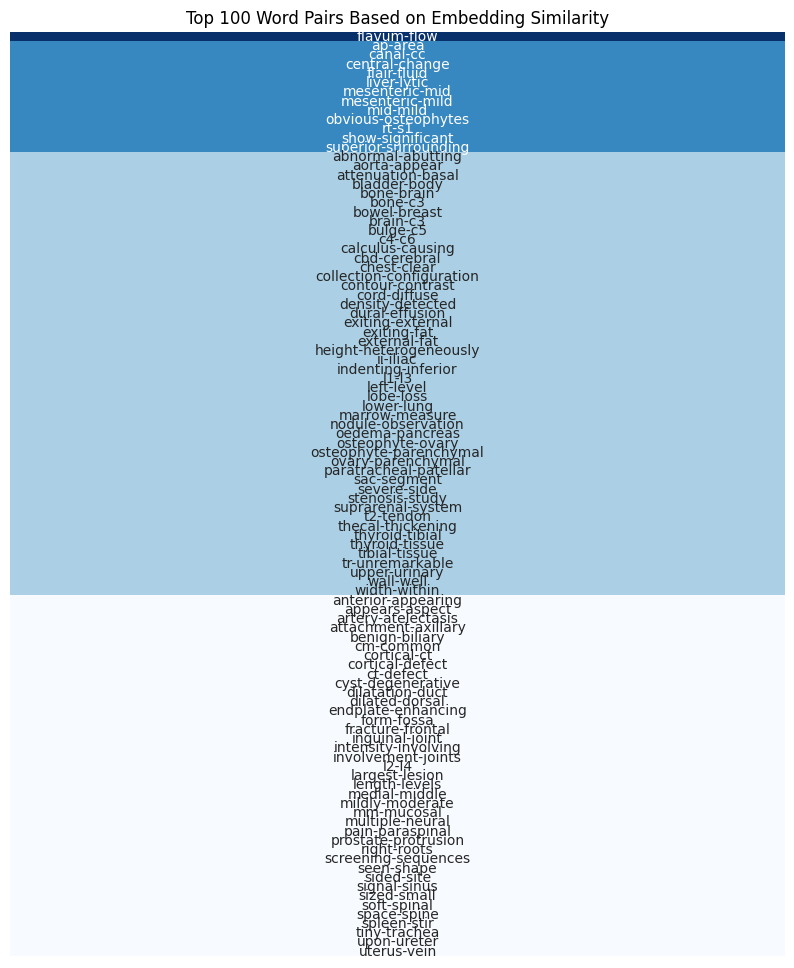

In [33]:
# Visualization of top word pairs
def visualize_word_pairs(word_pairs):
    # Prepare data for heatmap
    words, scores = zip(*[(f"{pair[0]}-{pair[1]}", pair[2]) for pair in word_pairs])

    # Since we have top 100 word pairs, reshape the scores into 2D
    scores_matrix = np.array(scores).reshape(len(scores), 1)

    # Plot heatmap with appropriate annotations
    plt.figure(figsize=(10, 12))
    sns.heatmap(scores_matrix, annot=np.array(words).reshape(len(words), 1), fmt='', cmap='Blues', cbar=False, xticklabels=False, yticklabels=False)
    plt.title('Top 100 Word Pairs Based on Embedding Similarity')
    plt.show()

# Call the visualization function
visualize_word_pairs(top_word_pairs)


In [34]:
pip install plotly


In [35]:
import plotly.express as px
import pandas as pd

# Convert top word pairs into a DataFrame for easier manipulation
def prepare_data_for_plot(word_pairs):
    word_pairs_data = {
        'Word Pair': [f"{pair[0]}-{pair[1]}" for pair in word_pairs],
        'Similarity Score': [pair[2] for pair in word_pairs]
    }
    return pd.DataFrame(word_pairs_data)

# Prepare data
word_pairs_df = prepare_data_for_plot(top_word_pairs)

# Create the interactive scatter plot
fig = px.scatter(
    word_pairs_df,
    x=range(len(word_pairs_df)),
    y='Similarity Score',
    hover_name='Word Pair',
    title='Top 100 Word Pairs Based on Embedding Similarity',
    labels={'x': 'Word Pair Index', 'Similarity Score': 'Cosine Similarity'}
)

# Customize layout for better interactivity
fig.update_layout(
    xaxis_title="Word Pair Index",
    yaxis_title="Cosine Similarity",
    hovermode="closest"
)

# Show the interactive plot
fig.show()
